In [283]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [284]:
def pad_sequences(data_list, max_length=None, pad_value=-100.0):
    """
    Pad variable length sequences to the same length
    
    Args:
        data_list: List of tensors with different sequence lengths
        max_length: Maximum length to pad to (default: longest sequence)
        pad_value: Value to use for padding
    
    Returns:
        padded_tensor: [batch_size, max_length, ...] - padded sequences
        seq_lengths: [batch_size] - original sequence lengths
    """
    if max_length is None:
        max_length = max(data.shape[0] for data in data_list) # Auto-calculate the max length

    batch_size = len(data_list) # Batch size
    seq_lengths = torch.tensor([data.shape[0] for data in data_list]) # Actual sequential length for each experiments
    dimensions = data_list[0].shape[1:] # Get shape of individual elements
    padded_tensor = torch.full((batch_size, max_length) + dimensions, pad_value, dtype=torch.float32) # generaste padded tensor filled with pad_value


    # Fill with actual data
    for i, data in enumerate(data_list):
        padded_tensor[i, :data.shape[0]] = torch.tensor(data[:data.shape[0]], dtype=torch.float32)
    
    return padded_tensor, seq_lengths, max_length

In [285]:
def prepare_input_data(Vt, E, C, Vm, seq_lengths=None):
    """
    Prepare input data for the model with padding support
    
    Args:
        voltage: [batch_size, seq_len] - applied voltage
        ext_electrolyte: [batch_size, seq_len] - external electrolyte concentration
        concentrations: [batch_size, seq_len, 3, 2] - [Feed, Acid, Base] x [LA, K] concentrations
        volumes: [batch_size, seq_len, 3] - volumes for each channel
        currents: [batch_size, seq_len] - measured currents
        seq_lengths: [batch_size] - actual sequence lengths (optional)
    
    Returns:
        input_tensor: [batch_size, seq_len, 3, 6] - formatted input for CNN-LSTM
        initial_state: [batch_size, 3, 3] - initial concentrations and volumes
        mask: [batch_size, seq_len] - padding mask
        seq_lengths: [batch_size] - actual sequence lengths
    """
    batch_size, seq_len = Vt.shape # Get batch size and sequence length for set the size of input tensor
    input = torch.zeros(batch_size, seq_len, 3, 5) # Generate input tensor

    # Fill input tensor for each channel
    for channel in range(3):
        input[:, :, channel, 0] = C[:, :, channel, 0] # LA concentration
        input[:, :, channel, 1] = C[:, :, channel, 1] # K concentration
        input[:, :, channel, 2] = Vm[:, :, channel] # Volume
        input[:, :, channel, 3] = Vt # Voltage (same for all)
        input[:, :, channel, 4] = E # Ext electrolyte (same for all)

    # Initial State for each channel
    init = torch.zeros(batch_size,3,3)
    init[:, :, 0] = C[:, 0, :, 0] # Initial LA concentrations [batch number, sequence length = 0 = initial state, channel number, feature]
    init[:, :, 1] = C[:, 0, :, 1] # Initial K concentrations
    init[:, :, 2] = Vm[:, 0, :] # Initial volumes

    # Create padding mask
    mask = torch.zeros(batch_size, seq_len)
    for i, length in enumerate(seq_lengths):
        mask[i, :length] = 1.0
    
    return input, init, mask, seq_lengths

In [286]:
def prepare_data(ndf):
    Vt_list, E_list, C_list, Vm_list, I_list, state_list = [], [], [], [], [], []

    for exp_num in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp_num]

        # operating conditions
        Vt_list.append(exp_data['V'].values)
        E_list.append(exp_data['E'].values)

        # concentrations
        CF_LA = exp_data['CF_LA'].values
        CF_K = exp_data['CF_K'].values
        CA_LA = exp_data['CA_LA'].values
        CA_K = exp_data['CA_K'].values
        CB_LA = exp_data['CB_LA'].values
        CB_K = exp_data['CB_K'].values

        # add channel dimension
        C_exp = np.stack([
            np.stack([CF_LA, CF_K], axis=1), # Feed
            np.stack([CA_LA, CA_K], axis=1), # Acid
            np.stack([CB_LA, CB_K], axis=1)  # Base
        ], axis=1)

        C_list.append(C_exp)
        Vm_list.append(exp_data[['VF', 'VA', 'VB']].values)

        I_list.append(exp_data['I'].values)

        seq_len = len(exp_data)
        state = np.zeros((seq_len, 3, 3))

        state[:, 0, 0] = CF_LA
        state[:, 0, 1] = CF_K
        state[:, 0, 2] = exp_data['VF'].values

        state[:, 1, 0] = CA_LA
        state[:, 1, 1] = CA_K
        state[:, 1, 2] = exp_data['VA'].values

        state[:, 2, 0] = CB_LA
        state[:, 2, 1] = CB_K 
        state[:, 2, 2] = exp_data['VB'].values

        state_list.append(state)

    return Vt_list, E_list, C_list, Vm_list, I_list, state_list

In [287]:
class BMEDDataset(Dataset):
    def __init__(self, inputs, init, masks, seq_lengths, I_targets, state_targets):
        self.inputs = inputs
        self.init = init
        self.masks = masks
        self.seq_lengths = seq_lengths
        self.I_targets = I_targets
        self.state_targets = state_targets

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return {
            'input': self.inputs[idx],
            'init': self.init[idx],
            'mask': self.masks[idx],
            'seq_length': self.seq_lengths[idx],
            'I_target': self.I_targets[idx],
            'state_target': self.state_targets[idx]
        }

In [288]:
class BMEDModel(nn.Module):
    def __init__(self, hidden_nodes = 64, num_rnn_layers = 2, cnn_channels = 32, max_seq_len = 37, dt=0.25):
        super(BMEDModel, self).__init__()

        # Input dimensions
        # 3 channels (Feed, Acid, Base) x 6 features each
        # Features per channel: C_LA, C_K, Vm, Vt, E
        self.input_channels = 3
        self.input_features = 5
        self.max_seq_len = max_seq_len
        self.dt = dt # time step

        # CNN Layers for channel-wise feature extraction
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(self.input_features, cnn_channels, kernel_size=3, padding=1), # 입력 특성을 cnn이 32개의 추출 특성을 생성
            nn.ReLU(), # 비선형성 부여
            nn.Conv1d(cnn_channels, cnn_channels//2, kernel_size=3, padding=1), # 추출 특성 중 중요 특성만 선별
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1) # 특성 추출 후 channel 축 차원 제거를 위한 평균값 산출
        )

        # Layer Normalization
        self.layer_norm = nn.LayerNorm(cnn_channels//2)

        # RNN layers for temporal dependency
        self.rnn_layers = nn.LSTM(
            input_size = cnn_channels//2,
            hidden_size = hidden_nodes,
            num_layers = num_rnn_layers,
            batch_first = True,
            dropout = 0.2 if num_rnn_layers > 1 else 0
        )

        # Flux Head
        self.flux_NN = nn.Sequential(
            nn.Linear(hidden_nodes, hidden_nodes//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_nodes//2, 4) # [LA ion migration, K ion migration, Water Migration Feed to Acid, Water Migration Feed to Base]
        )
        
        # Current Head
        self.current_NN = nn.Sequential(
            nn.Linear(hidden_nodes, hidden_nodes//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_nodes//2, 1)
        )

    def forward(self, x, initial_state, seq_lengths):
        '''
        x: [batch_size, sequence_length, channels, features]
        initial_state: [batch_size, channels, features] - initial concentration and volumes
        seq_lengths: [batch_size] - actual sequence lengths for each sample
        mask: [batch_size, sequence_length] - mask for padded positions

        Returns:
            current: [batch_size, seq_len] - predicted current
            states: [batch_size, seq_len, 3, 3] - predicted simulation restuls
        '''
        batch_size, seq_len, channels, features = x.shape

        # ====================== Neural Netowrk Part ======================

        # reshape for CNN processing
        x_cnn = x.view(batch_size*seq_len, channels, features)
        x_cnn = x_cnn.permute(0,2,1)

        # CNN feature extraction
        cnn_features = self.cnn_layers(x_cnn)   # [batch*seq, chaneels//2, 1]
        cnn_features = cnn_features.squeeze(-1) # [batch*seq, channels//2]

        # Reshape back for RNN
        rnn_input = cnn_features.view(batch_size, seq_len, -1)

        # Layer Normalization
        rnn_input = self.layer_norm(rnn_input)

        # Pack padded sequence for RNN
        rnn_input = nn.utils.rnn.pack_padded_sequence(
            rnn_input, seq_lengths.cpu(), batch_first = True, enforce_sorted=False
        )
        rnn_out, _ = self.rnn_layers(rnn_input)
        rnn_out, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True, total_length=self.max_seq_len) # pad 무시 후 다시 복원하여 layer 처리가 용이하도록 변경

        # Predict Fluxes for each time step
        fluxes = self.flux_NN(rnn_out) # [bath, seq_len, 4]

        # Predict Current for each time step
        current = self.current_NN(rnn_out) # [bath, seq_len, 1]
        current = current.squeeze(-1) # [batch, seq_len]

        # ====================== Physical Layer Part ======================

        new_states = self.physical_layer(fluxes, initial_state, seq_lengths)


        return current, new_states
    
    def physical_layer(self, fluxes, initial_state, seq_lengths):
        '''
        Physical simulation using predicted fluxes
        fluxes: [batch_size, seq_len, 4] - [LA migration, K migration, H2O Feed to Acid, H2O Feed to Base]
        initial_state: [batch_size, 3, 3] - [Feed, Acid, Base] x [LA_conc, K_conc, Volume]
        seq_lengths: [batch_size] - actual sequence lengths for each sample

        returns: [batch_size, seq_len, 3, 3] - time series of [LA_conc, K_conc, Volume] for each channel
        '''
        batch_size, seq_len, _ = fluxes.shape

        device = fluxes.device
        
        # initialize output tensor
        outputs = torch.zeros(batch_size, seq_len, 3, 3, device=device) # [batch, time, channel, property]

        # Set initial conditions
        cur_state = initial_state.clone() # [batch, channel, property]

        for t in range(seq_len):
            # Extract fluxes for current time step
            LA_flux = fluxes[:, t, 0] # LA migration (Feed -> Acid)
            K_flux = fluxes[:, t, 1] # K migration (Feed -> Base)
            VFA_flux = fluxes[:, t, 2] # H2O migration from Feed to Acid (Feed -> Acid)
            VFB_flux = fluxes[:, t, 3] # H2O migration from Feed to Base (Feed -> Base)


            # Only update if within actual sequence lengths
            time_mask = (t < seq_lengths).float()
            LA_flux = LA_flux * time_mask
            K_flux = K_flux * time_mask
            VFA_flux = VFA_flux * time_mask
            VFB_flux = VFB_flux * time_mask

            # Mass balance calculations
            cur_state = self.MB_step(cur_state, LA_flux, K_flux, VFA_flux, VFB_flux)

            # Store results
            outputs[:,t,:,:] = cur_state
        
        return outputs
    
    def MB_step(self, state, LA_flux, K_flux, VFA_flux, VFB_flux):
        '''
        Perfrom one time step of mass balance
        state: [batch, 3, 3] - [Feed, Acid, Base] x [LA_conc, K_conc, Volume]
        '''
        new_state = state.clone()

        # Extract current values
        # channel 0: feed, channel 1: acid, channel 2: base
        # property 0: LA_conc, property 1: K_conc, property 2: volume

        Feed_LA_Conc = state[:, 0, 0]
        Feed_K_Conc = state[:, 0, 1]
        Feed_Vol = state[:, 0, 2]

        Acid_LA_Conc = state[:, 1, 0]
        Acid_Vol = state[:, 1, 2]

        Base_K_Conc = state[:, 2, 1]
        Base_Vol = state[:, 2, 2]

        # Volume Changes due to water flux
        # Assuming positive flux means water moves from feed to acid or base
        new_state[:, 0, 2] = Feed_Vol - (VFA_flux + VFB_flux) * self.dt # Feed Volume
        new_state[:, 1, 2] = Acid_Vol + VFA_flux * self.dt # Acid Volume
        new_state[:, 2, 2] = Base_Vol + VFB_flux * self.dt # Base Volume

        # LA mass balance
        new_NF_LA = Feed_LA_Conc*Feed_Vol - LA_flux*self.dt
        new_NA_LA = Acid_LA_Conc*Acid_Vol + LA_flux*self.dt

        new_state[:, 0, 0] = new_NF_LA / (new_state[:, 0 ,2] + 1e-8) # new Feed LA concentration
        new_state[:, 1, 0] = new_NA_LA / (new_state[:, 1 ,2] + 1e-8) # new Acid LA concentration
        new_state[:, 2, 0] = state[:, 2, 0] # Base LA concentration remains unchanged

        # K mass balance
        new_NF_K = Feed_K_Conc*Feed_Vol - K_flux*self.dt
        new_NB_K = Base_K_Conc*Base_Vol + K_flux*self.dt

        new_state[:, 0, 1] = new_NF_K / (new_state[:, 0 ,2] + 1e-8) # new Feed K concentration
        new_state[:, 1, 1] = state[:, 1, 1] # Acid K concentration remains unchanged
        new_state[:, 2, 1] = new_NB_K / (new_state[:, 2 ,2] + 1e-8) # new Base K concentration
        
        return new_state

In [289]:
class BMEDLoss(nn.Module):
    def __init__(self, wt_i, wt_s):
        super(BMEDLoss, self).__init__()
        self.wt_i = wt_i
        self.wt_s = wt_s
        self.mse = nn.MSELoss(reduction='none') # to remove the effect of error at masked position

    def forward(self, pred_current, pred_states, target_current, target_states, masks, seq_lengths):
        current_loss = self.mse(pred_current, target_current)

        current_loss = current_loss * masks
        current_loss = current_loss.sum() / masks.sum()

        states_loss = self.mse(pred_states, target_states)
        expanded_mask = masks.unsqueeze(-1).unsqueeze(-1).expand_as(states_loss)
        states_loss = states_loss * expanded_mask
        states_loss = states_loss.sum() / expanded_mask.sum()

        total_loss = self.wt_i * current_loss + self.wt_s * states_loss

        return total_loss     


In [290]:
class NoamLR(torch.optim.lr_scheduler._LRScheduler):
    '''
    Pytorch LRScheduler 스타일으 Noam Scheduler
    '''

    def __init__(self, optimizer, d_model, warmup_steps=40, last_epoch=-1):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super(NoamLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        if step == 0:
            step  = 1

        lr_scale = (self.d_model ** -0.5) *min(
            step ** -0.5,
            step * (self.warmup_steps ** -1.5)
        )
        return [base_lr * lr_scale for base_lr in self.base_lrs]

In [291]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        # move to device
        inputs = batch['input'].to(device)
        init = batch['init'].to(device)
        masks = batch['mask'].to(device)
        seq_lengths = batch['seq_length'].to(device)
        I_targets = batch['I_target'].to(device)
        state_targets = batch['state_target'].to(device)

        # forward pass
        pred_current, pred_states = model(inputs, init, seq_lengths)

        # calculate loss
        loss = criterion(pred_current, pred_states, I_targets, state_targets, masks, seq_lengths)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [292]:
# def main():
#     # Set device
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     if torch.cuda.is_available():
#         print(f'Using device: {device}')
#         print(f'GPU: {torch.cuda.get_device_name(0)}')
#     else:
#         print(f'Using device: {device}')

#     # load data
#     df = pd.read_csv("BMED_DB_augmented.csv")
#     df['CA_K'] = 0.0
#     df['CB_LA'] = 0.0

#     # Robust min-max scaling including safety margin
#     ranges ={
#     'V' : {'min':0, 'max':50},
#     'E' : {'min':0, 'max':1},
#     'VF' : {'min':0, 'max':2},
#     'VA' : {'min':0, 'max':2},
#     'VB' : {'min':0, 'max':8},
#     'CF_LA' : {'min':-1, 'max':4},
#     'CA_LA' : {'min':-1, 'max':4},
#     'CF_K' : {'min':-1, 'max':7},
#     'CB_K' : {'min':-1, 'max':2},
#     'I' : {'min':0, 'max':5},
#     }

#     # Data normalization
#     ndf = pd.DataFrame()
#     ndf['exp'] = df['exp']; ndf['t'] = df['t']

#     for col in ['V', 'E', 'VF', 'VA', 'VB', 'CF_LA', 'CA_LA', 'CB_LA', 'CF_K', 'CA_K', 'CB_K', 'I']:
#         if col in ranges:
#             ndf[col] = (df[col] - ranges[col]['min'])/(ranges[col]['max'] - ranges[col]['min'])
#         else:
#             ndf[col] = df[col]
    
#     Vt_list, E_list, C_list, Vm_list, I_list, state_list = prepare_data(ndf)
    
#     # Pad sequences

#     Vt, seq_lengths, max_length = pad_sequences(Vt_list)
#     E, _, _ = pad_sequences(E_list,max_length = max_length)
#     C, _, _ = pad_sequences(C_list,max_length = max_length)
#     Vm, _, _ = pad_sequences(Vm_list,max_length = max_length)
#     I, _, _  = pad_sequences(I_list,max_length = max_length)
#     state, _, _ = pad_sequences(state_list,max_length = max_length)

#     # Prepare input data
#     input_tensor, init, mask, seq_lengths = prepare_input_data(Vt, E, C, Vm, seq_lengths)

#     # Generate Dataset by experiments
#     train_dataset = BMEDDataset(input_tensor, init, mask, seq_lengths, I, state)

#     # Generate DataLoader
#     train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

#     # Model Initialization
#     model = BMEDModel(
#         hidden_nodes=64,
#         num_rnn_layers=2,
#         cnn_channels=32,
#         max_seq_len=max_length,
#         dt=0.25
#     ).to(device)

#     # Training Set-up
#     criterion = BMEDLoss(wt_i=1.0, wt_s=1.0)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1.0)
#     scheduler = NoamLR(optimizer, d_model=64, warmup_steps=5*len(train_loader))

#     num_epochs = 50*len(train_loader)
#     train_losses = []

#     print("Start training...")

#     for epoch in range(num_epochs):
#         train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

#         # Record loss
#         train_losses.append(train_loss)

#         # Update learning rate
#         scheduler.step()

#         # Print progress
#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')


# main()

In [293]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'Using device: {device}')
    print(f'GPU: {torch.cuda.get_device_name(0)}')
else:
    print(f'Using device: {device}')

# load data
df = pd.read_csv("BMED_DB_augmented.csv")
df['CA_K'] = 0.0
df['CB_LA'] = 0.0
df = df[df['exp'].isin([0, 1])].reset_index(drop=True)


# Robust min-max scaling including safety margin
ranges ={
'V' : {'min':0, 'max':50},
'E' : {'min':0, 'max':1},
'VF' : {'min':0, 'max':2},
'VA' : {'min':0, 'max':2},
'VB' : {'min':0, 'max':8},
'CF_LA' : {'min':-1, 'max':4},
'CA_LA' : {'min':-1, 'max':4},
'CF_K' : {'min':-1, 'max':7},
'CB_K' : {'min':-1, 'max':2},
'I' : {'min':0, 'max':5},
}

# Data normalization
ndf = pd.DataFrame()
ndf['exp'] = df['exp']; ndf['t'] = df['t']

for col in ['V', 'E', 'VF', 'VA', 'VB', 'CF_LA', 'CA_LA', 'CB_LA', 'CF_K', 'CA_K', 'CB_K', 'I']:
    if col in ranges:
        ndf[col] = (df[col] - ranges[col]['min'])/(ranges[col]['max'] - ranges[col]['min'])
    else:
        ndf[col] = df[col]

Vt_list, E_list, C_list, Vm_list, I_list, state_list = prepare_data(ndf)

# Pad sequences

Vt, seq_lengths, max_length = pad_sequences(Vt_list)
E, _, _ = pad_sequences(E_list,max_length = max_length)
C, _, _ = pad_sequences(C_list,max_length = max_length)
Vm, _, _ = pad_sequences(Vm_list,max_length = max_length)
I, _, _  = pad_sequences(I_list,max_length = max_length)
state, _, _ = pad_sequences(state_list,max_length = max_length)

# Prepare input data
input_tensor, init, mask, seq_lengths = prepare_input_data(Vt, E, C, Vm, seq_lengths)

# Generate Dataset by experiments
train_dataset = BMEDDataset(input_tensor, init, mask, seq_lengths, I, state)

# Generate DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Model Initialization
model = BMEDModel(
    hidden_nodes=128,
    num_rnn_layers=10,
    cnn_channels=128,
    max_seq_len=max_length,
    dt=0.25
).to(device)

# Training Set-up
criterion = BMEDLoss(wt_i=1.0, wt_s=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0)
scheduler = NoamLR(optimizer, d_model=64, warmup_steps=5*len(train_loader))

num_epochs = 1000
train_losses = []

print("Start training...")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Record loss
    train_losses.append(train_loss)

    # Update learning rate
    scheduler.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Using device: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER
Start training...
Epoch [10/1000], Loss: 6.9173, Learning Rate: 0.037689
Epoch [20/1000], Loss: 0.0407, Learning Rate: 0.027277
Epoch [30/1000], Loss: 0.0123, Learning Rate: 0.022451
Epoch [40/1000], Loss: 0.0051, Learning Rate: 0.019522
Epoch [50/1000], Loss: 0.0035, Learning Rate: 0.017504
Epoch [60/1000], Loss: 0.0040, Learning Rate: 0.016005
Epoch [70/1000], Loss: 0.0034, Learning Rate: 0.014835
Epoch [80/1000], Loss: 0.0032, Learning Rate: 0.013889
Epoch [90/1000], Loss: 0.0037, Learning Rate: 0.013104
Epoch [100/1000], Loss: 0.0035, Learning Rate: 0.012438
Epoch [110/1000], Loss: 0.0033, Learning Rate: 0.011864
Epoch [120/1000], Loss: 0.0033, Learning Rate: 0.011364
Epoch [130/1000], Loss: 0.0034, Learning Rate: 0.010921
Epoch [140/1000], Loss: 0.0038, Learning Rate: 0.010527
Epoch [150/1000], Loss: 0.0036, Learning Rate: 0.010172
Epoch [160/1000], Loss: 0.0043, Learning Rate: 0.009851
Epoch [170/1000], Loss: 0.0037, Learning 

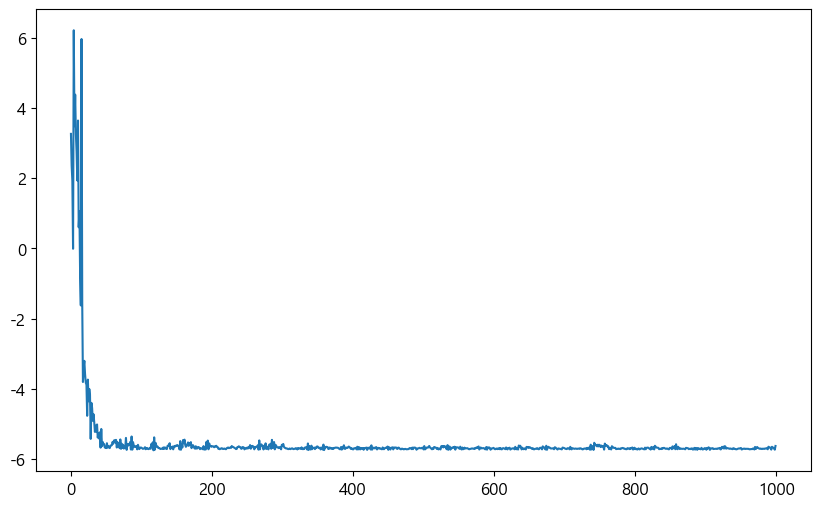

In [294]:
plt.plot(np.log(train_losses))

모델 평가 및 비교 플롯 생성 중...


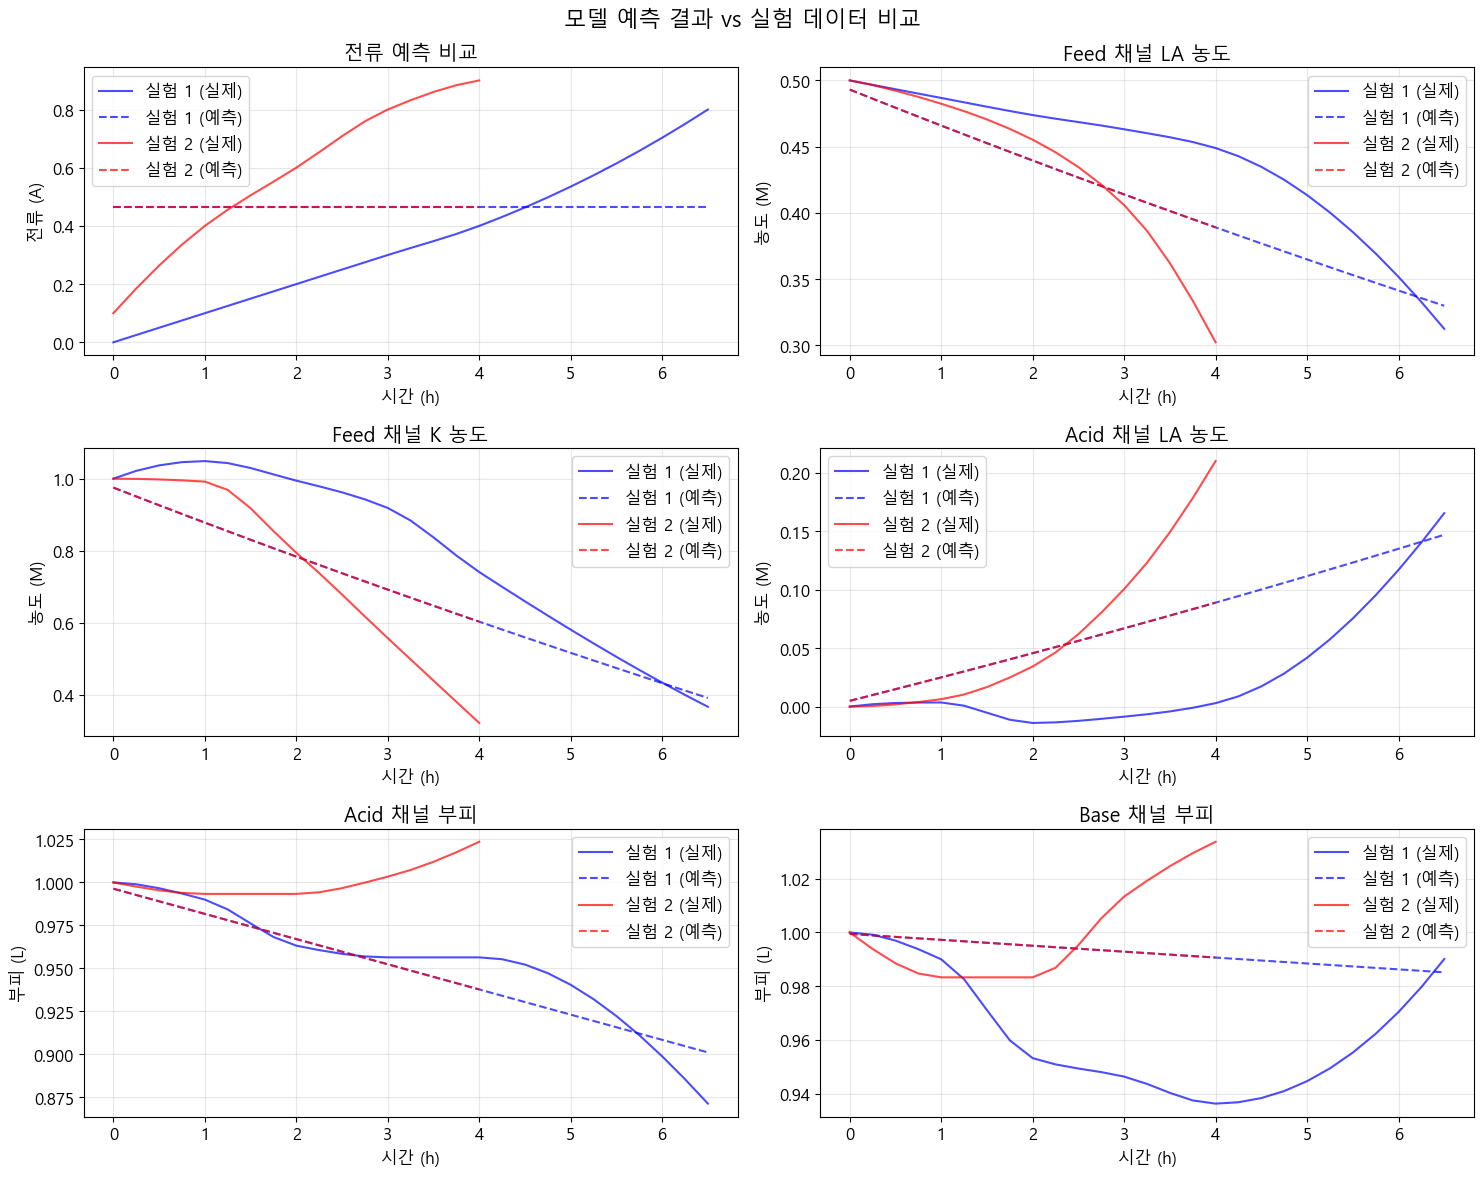

=== 모델 성능 지표 ===
전류 예측 MSE: 0.002750
전류 예측 MAE: 0.045178
상태 예측 MSE: 0.000598
상태 예측 MAE: 0.012782

Parity Plot 생성 중...


c:\micromamba\envs\torchenv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\micromamba\envs\torchenv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


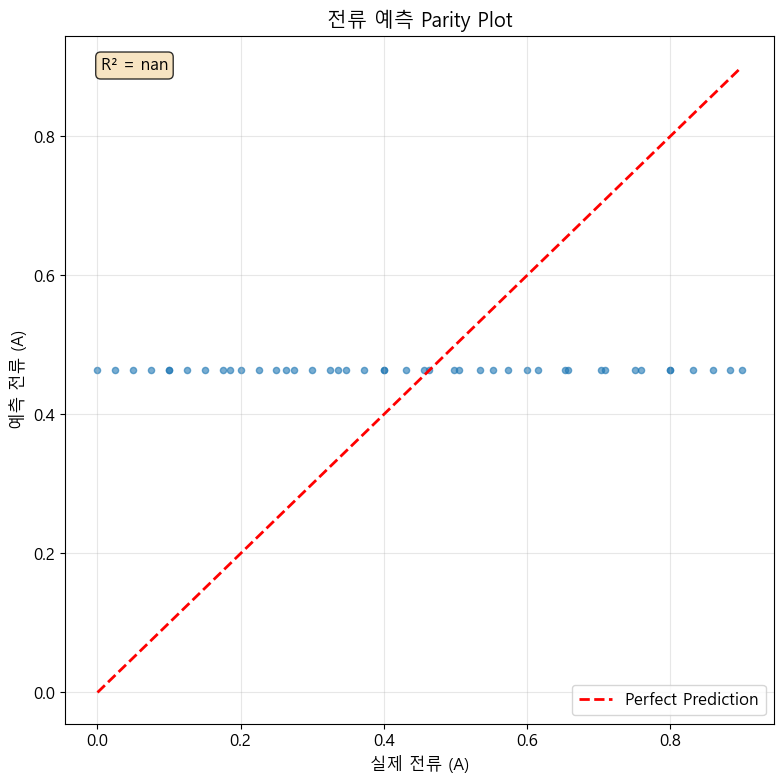

In [295]:
# 모델 평가 및 예측 결과 비교 플롯

def denormalize_data(normalized_data, col_name, ranges):
    """정규화된 데이터를 원래 스케일로 복원"""
    if col_name in ranges:
        min_val = ranges[col_name]['min']
        max_val = ranges[col_name]['max']
        return normalized_data * (max_val - min_val) + min_val
    return normalized_data

def evaluate_model_and_plot(model, dataloader, ranges, device, num_experiments_to_plot=3):
    """모델 평가 및 예측 결과 플롯"""
    model.eval()
    
    all_predictions_current = []
    all_targets_current = []
    all_predictions_states = []
    all_targets_states = []
    all_seq_lengths = []
    all_masks = []
    
    # 예측 수행
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input'].to(device)
            init = batch['init'].to(device)
            masks = batch['mask'].to(device)
            seq_lengths = batch['seq_length'].to(device)
            I_targets = batch['I_target'].to(device)
            state_targets = batch['state_target'].to(device)
            
            # 예측
            pred_current, pred_states = model(inputs, init, seq_lengths)
            
            # 결과 저장
            all_predictions_current.append(pred_current.cpu())
            all_targets_current.append(I_targets.cpu())
            all_predictions_states.append(pred_states.cpu())
            all_targets_states.append(state_targets.cpu())
            all_seq_lengths.append(seq_lengths.cpu())
            all_masks.append(masks.cpu())
    
    # 텐서 연결
    pred_current_all = torch.cat(all_predictions_current, dim=0)
    target_current_all = torch.cat(all_targets_current, dim=0)
    pred_states_all = torch.cat(all_predictions_states, dim=0)
    target_states_all = torch.cat(all_targets_states, dim=0)
    seq_lengths_all = torch.cat(all_seq_lengths, dim=0)
    masks_all = torch.cat(all_masks, dim=0)
    
    # 플롯 생성
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('모델 예측 결과 vs 실험 데이터 비교', fontsize=16)
    
    # 몇 개의 실험만 선택해서 플롯
    num_experiments = min(num_experiments_to_plot, pred_current_all.shape[0])
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for exp_idx in range(num_experiments):
        seq_len = seq_lengths_all[exp_idx].item()
        time_points = np.arange(seq_len) * 0.25  # dt = 0.25
        
        color = colors[exp_idx % len(colors)]
        
        # 1. 전류 비교
        ax1 = axes[0, 0]
        pred_current_denorm = denormalize_data(pred_current_all[exp_idx, :seq_len], 'I', ranges)
        target_current_denorm = denormalize_data(target_current_all[exp_idx, :seq_len], 'I', ranges)
        
        ax1.plot(time_points, target_current_denorm, '-', color=color, label=f'실험 {exp_idx+1} (실제)', alpha=0.7)
        ax1.plot(time_points, pred_current_denorm, '--', color=color, label=f'실험 {exp_idx+1} (예측)', alpha=0.7)
        
        ax1.set_xlabel('시간 (h)')
        ax1.set_ylabel('전류 (A)')
        ax1.set_title('전류 예측 비교')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Feed 채널 LA 농도
        ax2 = axes[0, 1]
        pred_CF_LA = denormalize_data(pred_states_all[exp_idx, :seq_len, 0, 0], 'CF_LA', ranges)
        target_CF_LA = denormalize_data(target_states_all[exp_idx, :seq_len, 0, 0], 'CF_LA', ranges)
        
        ax2.plot(time_points, target_CF_LA, '-', color=color, label=f'실험 {exp_idx+1} (실제)', alpha=0.7)
        ax2.plot(time_points, pred_CF_LA, '--', color=color, label=f'실험 {exp_idx+1} (예측)', alpha=0.7)
        
        ax2.set_xlabel('시간 (h)')
        ax2.set_ylabel('농도 (M)')
        ax2.set_title('Feed 채널 LA 농도')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Feed 채널 K 농도
        ax3 = axes[1, 0]
        pred_CF_K = denormalize_data(pred_states_all[exp_idx, :seq_len, 0, 1], 'CF_K', ranges)
        target_CF_K = denormalize_data(target_states_all[exp_idx, :seq_len, 0, 1], 'CF_K', ranges)
        
        ax3.plot(time_points, target_CF_K, '-', color=color, label=f'실험 {exp_idx+1} (실제)', alpha=0.7)
        ax3.plot(time_points, pred_CF_K, '--', color=color, label=f'실험 {exp_idx+1} (예측)', alpha=0.7)
        
        ax3.set_xlabel('시간 (h)')
        ax3.set_ylabel('농도 (M)')
        ax3.set_title('Feed 채널 K 농도')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Acid 채널 LA 농도
        ax4 = axes[1, 1]
        pred_CA_LA = denormalize_data(pred_states_all[exp_idx, :seq_len, 1, 0], 'CA_LA', ranges)
        target_CA_LA = denormalize_data(target_states_all[exp_idx, :seq_len, 1, 0], 'CA_LA', ranges)
        
        ax4.plot(time_points, target_CA_LA, '-', color=color, label=f'실험 {exp_idx+1} (실제)', alpha=0.7)
        ax4.plot(time_points, pred_CA_LA, '--', color=color, label=f'실험 {exp_idx+1} (예측)', alpha=0.7)
        
        ax4.set_xlabel('시간 (h)')
        ax4.set_ylabel('농도 (M)')
        ax4.set_title('Acid 채널 LA 농도')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Acid 채널 부피
        ax5 = axes[2, 0]
        pred_VA = denormalize_data(pred_states_all[exp_idx, :seq_len, 1, 2], 'VA', ranges)
        target_VA = denormalize_data(target_states_all[exp_idx, :seq_len, 1, 2], 'VA', ranges)
        
        ax5.plot(time_points, target_VA, '-', color=color, label=f'실험 {exp_idx+1} (실제)', alpha=0.7)
        ax5.plot(time_points, pred_VA, '--', color=color, label=f'실험 {exp_idx+1} (예측)', alpha=0.7)
        
        ax5.set_xlabel('시간 (h)')
        ax5.set_ylabel('부피 (L)')
        ax5.set_title('Acid 채널 부피')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Base 채널 부피
        ax6 = axes[2, 1]
        pred_VB = denormalize_data(pred_states_all[exp_idx, :seq_len, 2, 2], 'VB', ranges)
        target_VB = denormalize_data(target_states_all[exp_idx, :seq_len, 2, 2], 'VB', ranges)
        
        ax6.plot(time_points, target_VB, '-', color=color, label=f'실험 {exp_idx+1} (실제)', alpha=0.7)
        ax6.plot(time_points, pred_VB, '--', color=color, label=f'실험 {exp_idx+1} (예측)', alpha=0.7)
        
        ax6.set_xlabel('시간 (h)')
        ax6.set_ylabel('부피 (L)')
        ax6.set_title('Base 채널 부피')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 전체적인 성능 지표 계산 (안전한 방법)
    print("=== 모델 성능 지표 ===")
    
    # 전류 예측 성능
    current_mask = masks_all.bool()
    pred_current_masked = pred_current_all[current_mask]
    target_current_masked = target_current_all[current_mask]
    
    current_mse = torch.mean((pred_current_masked - target_current_masked)**2)
    current_mae = torch.mean(torch.abs(pred_current_masked - target_current_masked))
    
    print(f"전류 예측 MSE: {current_mse:.6f}")
    print(f"전류 예측 MAE: {current_mae:.6f}")
    
    # 상태 예측 성능 - 마스크를 각 실험별로 적용
    states_mse_list = []
    states_mae_list = []
    
    for i in range(pred_states_all.shape[0]):
        seq_len = seq_lengths_all[i].item()
        pred_states_exp = pred_states_all[i, :seq_len, :, :]
        target_states_exp = target_states_all[i, :seq_len, :, :]
        
        mse = torch.mean((pred_states_exp - target_states_exp)**2)
        mae = torch.mean(torch.abs(pred_states_exp - target_states_exp))
        
        states_mse_list.append(mse)
        states_mae_list.append(mae)
    
    states_mse = torch.mean(torch.stack(states_mse_list))
    states_mae = torch.mean(torch.stack(states_mae_list))
    
    print(f"상태 예측 MSE: {states_mse:.6f}")
    print(f"상태 예측 MAE: {states_mae:.6f}")

def create_parity_plot(model, dataloader, ranges, device):
    """Parity plot (예측값 vs 실제값 산점도) 생성"""
    model.eval()
    
    all_pred_current = []
    all_target_current = []
    all_pred_states = []
    all_target_states = []
    all_masks = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input'].to(device)
            init = batch['init'].to(device)
            masks = batch['mask'].to(device)
            seq_lengths = batch['seq_length'].to(device)
            I_targets = batch['I_target'].to(device)
            state_targets = batch['state_target'].to(device)
            
            pred_current, pred_states = model(inputs, init, seq_lengths)
            
            all_pred_current.append(pred_current.cpu())
            all_target_current.append(I_targets.cpu())
            all_pred_states.append(pred_states.cpu())
            all_target_states.append(state_targets.cpu())
            all_masks.append(masks.cpu())
    
    pred_current_all = torch.cat(all_pred_current, dim=0)
    target_current_all = torch.cat(all_target_current, dim=0)
    pred_states_all = torch.cat(all_pred_states, dim=0)
    target_states_all = torch.cat(all_target_states, dim=0)
    masks_all = torch.cat(all_masks, dim=0)
    
    # 마스크 적용
    current_mask = masks_all.bool()
    pred_current_masked = pred_current_all[current_mask]
    target_current_masked = target_current_all[current_mask]
    
    # 비정규화
    pred_current_denorm = denormalize_data(pred_current_masked, 'I', ranges)
    target_current_denorm = denormalize_data(target_current_masked, 'I', ranges)
    
    # Parity plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.scatter(target_current_denorm, pred_current_denorm, alpha=0.6, s=20)
    
    # 완벽한 예측 라인 (y=x)
    min_val = min(target_current_denorm.min(), pred_current_denorm.min())
    max_val = max(target_current_denorm.max(), pred_current_denorm.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('실제 전류 (A)')
    ax.set_ylabel('예측 전류 (A)')
    ax.set_title('전류 예측 Parity Plot')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # R² 계산
    correlation_matrix = np.corrcoef(target_current_denorm.numpy(), pred_current_denorm.numpy())
    r_squared = correlation_matrix[0, 1] ** 2
    ax.text(0.05, 0.95, f'R² = {r_squared:.4f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# 실행
print("모델 평가 및 비교 플롯 생성 중...")
evaluate_model_and_plot(model, train_loader, ranges, device, num_experiments_to_plot=3)

print("\nParity Plot 생성 중...")
create_parity_plot(model, train_loader, ranges, device)